**BUAN6341: Assignment 3**    
_Adityan Rajendran - axr180073_

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
# Confusion Matrix plotting function definition
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    if not title:
        title = 'Confusion matrix for best model'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #return ax

    fig2 = plt.figure(figsize=(10, 2))
    ax2 = plt.subplot(111)
    ax2.axis('off')

    acc = round((cm[0,0] + cm[1,1])/sum(cm[0]+cm[1]),4)
    rec = round(((cm[0,0])/sum(cm[0])),4)
    prec = round((cm[0,0]/(cm[0,0]+cm[1,0])),4)
    f1 = round((2 * (prec * rec)) / (prec + rec), 4)
    colLabels1 = ['Metrics','Values']
    cellText1 = [['Accuracy', acc],
            ['Recall', rec],
            ['Precision', prec],
            ['F1 Score', f1]]
    colColours1 = ['#56b5fd','lightgray']
    rowColours1 = [['lightgray','w'],['lightgray','w'],['lightgray','w'], ['lightgray','w']]
    tab = ax2.table(cellText=cellText1, colLabels=colLabels1, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours1, colColours=colColours1)
    #tab = ax2.table(cellText=cellText1, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours1, colColours=colColours1)
    tab.auto_set_font_size(False)
    tab.set_fontsize(14)
    return ax,ax2

**Dataset 1 - Energy Data**  
_Data pre-processing and cleaning_

In [36]:
## Dataset 1 - Energy data
# Converting 'Energy' dataset into binary classification problem
energy_data = pd.read_csv('energydata_complete.csv')
energy_data.drop(['date','rv1','rv2'], axis = 1, inplace = True) ##Dropping date column as it is not needed

# Coverting to binary classification
target_col = 'Appliances'
for i in range(len(energy_data)):
    if(energy_data['Appliances'].values[i] <= 60):
        energy_data['Appliances'].values[i] = 0
    else:
        energy_data['Appliances'].values[i] = 1

dt_data = energy_data.copy(deep=True)

# Feature scaling - Mean normalization
for col in energy_data.columns:
    if(col != 'Appliances'):
        energy_data[col] = (energy_data[col] - energy_data[col].mean())/energy_data[col].std()
        
# Train test split       
from sklearn.model_selection import train_test_split
d1_train, d1_test = train_test_split(energy_data, test_size = 0.3, random_state = 40)

d1_train_y = d1_train[target_col]
d1_train_x = d1_train.loc[:, d1_train.columns!=target_col]

d1_test_y = d1_test[target_col]
d1_test_x = d1_test.loc[:, d1_test.columns!=target_col]

**Dataset 2 - Audit Data**  
_Data pre-processing and cleaning_

In [37]:
## Dataset 2 - Audit dataset
audit_data = pd.read_csv('trial.csv')
audit_data.drop(['LOCATION_ID','TOTAL','Score'], axis = 1, inplace = True) ##Dropping ID; Dropping TOTAL column as it is redundant
audit_data['Money_Value'].fillna((audit_data['Money_Value'].mean()), inplace = True) #Fixing NA value

Y2 = audit_data['Risk'].copy()
X2 = audit_data.loc[:, audit_data.columns!='Risk']

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X2 = StandardScaler()
X2_scaled = pd.DataFrame(sc_X2.fit_transform(X2))
 
# Train Test split
from sklearn.model_selection import train_test_split,cross_val_score
d2_train_x, d2_test_x, d2_train_y, d2_test_y = train_test_split(X2_scaled, Y2, test_size = 0.3,stratify=Y2, random_state = 4)

**TASKS BEGIN**   
**TASK 1 - Neural Nets**

In [38]:
#Neural nets model - function definition
from sklearn.neural_network import MLPClassifier
random_num = 40

def neural(x, y, activation_func, hidden_layer_size, max_iters, learning_r):
    if(max_iters>0):
        neural_mod = MLPClassifier(activation=activation_func, hidden_layer_sizes=hidden_layer_size, max_iter=max_iters, learning_rate=learning_r, random_state=random_num)
    else:
        neural_mod = MLPClassifier(activation=activation_func, hidden_layer_sizes=hidden_layer_size, learning_rate=learning_r, random_state=random_num)   
    neural_mod.fit(x,y)
    return(neural_mod)

In [39]:
n_max_iters = 200
n_learning_rate = 'constant' #adaptive, invscaling
n_hidden_layer_size = [100]

In [40]:
#n_mod = neural(d1_train_x, d1_train_y, 'logistic', [100,100], 0, n_learning_rate)
#n_mod.score(d1_test_x, d1_test_y)

**Experiment 1.1 - Experimentation with Activation functions**

_Dataset 1: Energy Data_

In [41]:
d1_ex11_func = ['logistic','tanh','relu']
d1_ex11_maxiter = [200,300,400,500,600]
d1_ex11_train_acc_matrix = {}
d1_ex11_test_acc_matrix = {}
d1_ex11_train_err_matrix = {}
d1_ex11_test_err_matrix = {}

for f in d1_ex11_func:
    d1_ex11_train_acc = []
    d1_ex11_train_err = []
    d1_ex11_test_acc = []
    d1_ex11_test_err = []
    for m in d1_ex11_maxiter:
        d1_ex11_nn_mod = neural(d1_train_x, d1_train_y, f, n_hidden_layer_size, m, n_learning_rate)
        d1_ex11_train_acc.append(d1_ex11_nn_mod.score(d1_train_x,d1_train_y))
        d1_ex11_train_err.append(1-d1_ex11_nn_mod.score(d1_train_x, d1_train_y))
        d1_ex11_test_acc.append(d1_ex11_nn_mod.score(d1_test_x,d1_test_y))
        d1_ex11_test_err.append(1-d1_ex11_nn_mod.score(d1_test_x,d1_test_y))
    d1_ex11_train_acc_matrix[f] = d1_ex11_train_acc
    d1_ex11_train_err_matrix[f] = d1_ex11_train_err
    d1_ex11_test_acc_matrix[f] = d1_ex11_test_acc
    d1_ex11_test_err_matrix[f] = d1_ex11_test_err

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

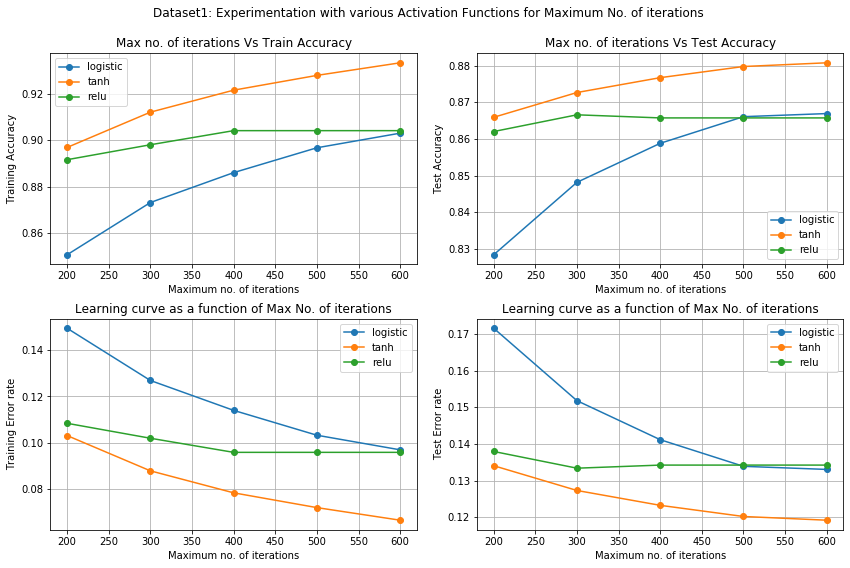

In [42]:
fig_d1_ex11, ax_d1_ex11 = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

ax_d1_ex11[0,0].plot(d1_ex11_maxiter, d1_ex11_train_acc_matrix['logistic'], 'o-', label='logistic')
ax_d1_ex11[0,0].plot(d1_ex11_maxiter, d1_ex11_train_acc_matrix['tanh'], 'o-', label='tanh')
ax_d1_ex11[0,0].plot(d1_ex11_maxiter, d1_ex11_train_acc_matrix['relu'], 'o-', label='relu')
ax_d1_ex11[0,0].set(xlabel='Maximum no. of iterations', ylabel='Training Accuracy', title='Max no. of iterations Vs Train Accuracy')
ax_d1_ex11[0,0].grid()
ax_d1_ex11[0,0].legend(loc='best')

ax_d1_ex11[0,1].plot(d1_ex11_maxiter, d1_ex11_test_acc_matrix['logistic'], 'o-', label='logistic')
ax_d1_ex11[0,1].plot(d1_ex11_maxiter, d1_ex11_test_acc_matrix['tanh'], 'o-', label='tanh')
ax_d1_ex11[0,1].plot(d1_ex11_maxiter, d1_ex11_test_acc_matrix['relu'], 'o-', label='relu')
ax_d1_ex11[0,1].set(xlabel='Maximum no. of iterations', ylabel='Test Accuracy', title='Max no. of iterations Vs Test Accuracy')
ax_d1_ex11[0,1].grid()
ax_d1_ex11[0,1].legend(loc='best')

ax_d1_ex11[1,0].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['logistic'], 'o-', label='logistic')
ax_d1_ex11[1,0].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['tanh'], 'o-', label='tanh')
ax_d1_ex11[1,0].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['relu'], 'o-', label='relu')
ax_d1_ex11[1,0].set(xlabel='Maximum no. of iterations', ylabel='Training Error rate', title='Learning curve as a function of Max No. of iterations')
ax_d1_ex11[1,0].grid()
ax_d1_ex11[1,0].legend(loc='best')

ax_d1_ex11[1,1].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['logistic'], 'o-', label='logistic')
ax_d1_ex11[1,1].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['tanh'], 'o-', label='tanh')
ax_d1_ex11[1,1].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['relu'], 'o-', label='relu')
ax_d1_ex11[1,1].set(xlabel='Maximum no. of iterations', ylabel='Test Error rate', title='Learning curve as a function of Max No. of iterations')
ax_d1_ex11[1,1].grid()
ax_d1_ex11[1,1].legend(loc='best')

fig_d1_ex11.tight_layout()
fig_d1_ex11.suptitle('Dataset1: Experimentation with various Activation Functions for Maximum No. of iterations')
fig_d1_ex11.subplots_adjust(top=0.90)

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x18a8a6e8b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8a0f8c18>)

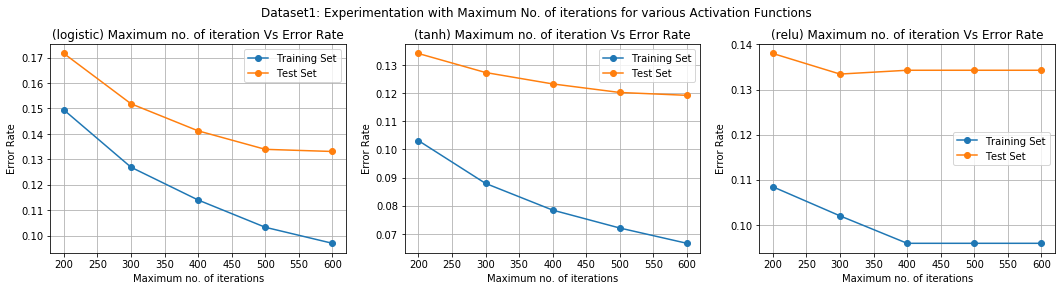

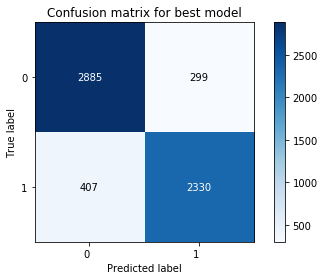

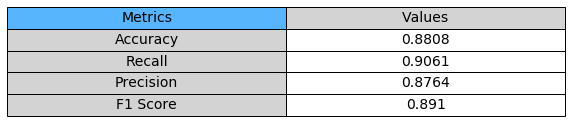

In [43]:
fig_d1_ex11_2, ax_d1_ex11_2 = plt.subplots(ncols=3, nrows=1, figsize=(18,4))

ax_d1_ex11_2[0].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['logistic'], 'o-', label='Training Set')
ax_d1_ex11_2[0].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['logistic'], 'o-', label='Test Set')
ax_d1_ex11_2[0].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(logistic) Maximum no. of iteration Vs Error Rate')
ax_d1_ex11_2[0].grid()
ax_d1_ex11_2[0].legend(loc='best')

ax_d1_ex11_2[1].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['tanh'], 'o-', label='Training Set')
ax_d1_ex11_2[1].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['tanh'], 'o-', label='Test Set')
ax_d1_ex11_2[1].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(tanh) Maximum no. of iteration Vs Error Rate')
ax_d1_ex11_2[1].grid()
ax_d1_ex11_2[1].legend(loc='best')

ax_d1_ex11_2[2].plot(d1_ex11_maxiter, d1_ex11_train_err_matrix['relu'], 'o-', label='Training Set')
ax_d1_ex11_2[2].plot(d1_ex11_maxiter, d1_ex11_test_err_matrix['relu'], 'o-', label='Test Set')
ax_d1_ex11_2[2].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(relu) Maximum no. of iteration Vs Error Rate')
ax_d1_ex11_2[2].grid()
ax_d1_ex11_2[2].legend(loc='best')

fig_d1_ex11_2.suptitle('Dataset1: Experimentation with Maximum No. of iterations for various Activation Functions')
fig_d1_ex11_2.subplots_adjust(top=0.85)

# Best model is for activation function = 'tanh', maximum iterations = 600
d1_ex11_nn_2_mod = neural(d1_train_x, d1_train_y, 'tanh', n_hidden_layer_size, 600, n_learning_rate)
plot_confusion_matrix(d1_test_y, d1_ex11_nn_2_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [44]:
d2_ex11_func = ['logistic','tanh','relu']
d2_ex11_maxiter = [50,100,150,200,250,300]
d2_ex11_train_acc_matrix = {}
d2_ex11_test_acc_matrix = {}
d2_ex11_train_err_matrix = {}
d2_ex11_test_err_matrix = {}

for f in d2_ex11_func:
    d2_ex11_train_acc = []
    d2_ex11_train_err = []
    d2_ex11_test_acc = []
    d2_ex11_test_err = []
    for m in d2_ex11_maxiter:
        d2_ex11_nn_mod = neural(d2_train_x, d2_train_y, f, n_hidden_layer_size, m, n_learning_rate)
        d2_ex11_train_acc.append(d2_ex11_nn_mod.score(d2_train_x,d2_train_y))
        d2_ex11_train_err.append(1-d2_ex11_nn_mod.score(d2_train_x, d2_train_y))
        d2_ex11_test_acc.append(d2_ex11_nn_mod.score(d2_test_x,d2_test_y))
        d2_ex11_test_err.append(1-d2_ex11_nn_mod.score(d2_test_x,d2_test_y))
    d2_ex11_train_acc_matrix[f] = d2_ex11_train_acc
    d2_ex11_train_err_matrix[f] = d2_ex11_train_err
    d2_ex11_test_acc_matrix[f] = d2_ex11_test_acc
    d2_ex11_test_err_matrix[f] = d2_ex11_test_err

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Convergen

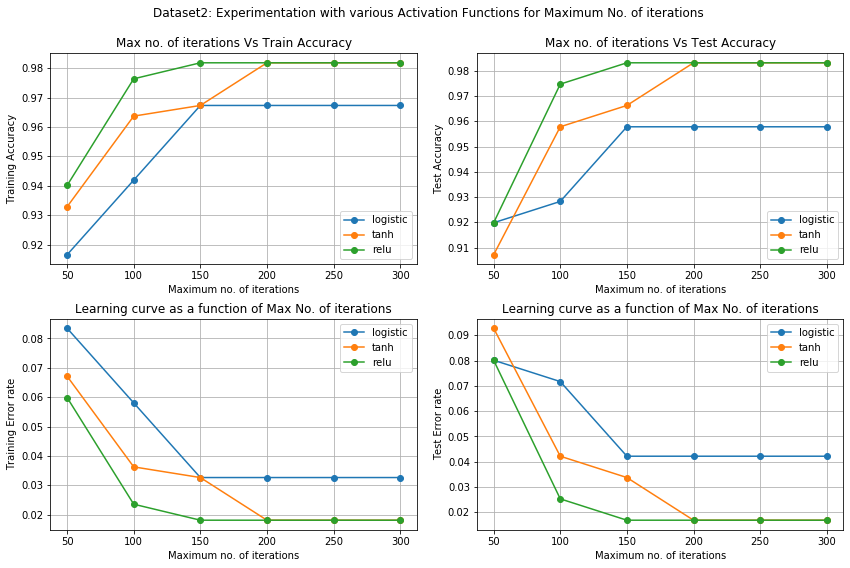

In [45]:
fig_d2_ex11, ax_d2_ex11 = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

ax_d2_ex11[0,0].plot(d2_ex11_maxiter, d2_ex11_train_acc_matrix['logistic'], 'o-', label='logistic')
ax_d2_ex11[0,0].plot(d2_ex11_maxiter, d2_ex11_train_acc_matrix['tanh'], 'o-', label='tanh')
ax_d2_ex11[0,0].plot(d2_ex11_maxiter, d2_ex11_train_acc_matrix['relu'], 'o-', label='relu')
ax_d2_ex11[0,0].set(xlabel='Maximum no. of iterations', ylabel='Training Accuracy', title='Max no. of iterations Vs Train Accuracy')
ax_d2_ex11[0,0].grid()
ax_d2_ex11[0,0].legend(loc='best')

ax_d2_ex11[0,1].plot(d2_ex11_maxiter, d2_ex11_test_acc_matrix['logistic'], 'o-', label='logistic')
ax_d2_ex11[0,1].plot(d2_ex11_maxiter, d2_ex11_test_acc_matrix['tanh'], 'o-', label='tanh')
ax_d2_ex11[0,1].plot(d2_ex11_maxiter, d2_ex11_test_acc_matrix['relu'], 'o-', label='relu')
ax_d2_ex11[0,1].set(xlabel='Maximum no. of iterations', ylabel='Test Accuracy', title='Max no. of iterations Vs Test Accuracy')
ax_d2_ex11[0,1].grid()
ax_d2_ex11[0,1].legend(loc='best')

ax_d2_ex11[1,0].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['logistic'], 'o-', label='logistic')
ax_d2_ex11[1,0].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['tanh'], 'o-', label='tanh')
ax_d2_ex11[1,0].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['relu'], 'o-', label='relu')
ax_d2_ex11[1,0].set(xlabel='Maximum no. of iterations', ylabel='Training Error rate', title='Learning curve as a function of Max No. of iterations')
ax_d2_ex11[1,0].grid()
ax_d2_ex11[1,0].legend(loc='best')

ax_d2_ex11[1,1].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['logistic'], 'o-', label='logistic')
ax_d2_ex11[1,1].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['tanh'], 'o-', label='tanh')
ax_d2_ex11[1,1].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['relu'], 'o-', label='relu')
ax_d2_ex11[1,1].set(xlabel='Maximum no. of iterations', ylabel='Test Error rate', title='Learning curve as a function of Max No. of iterations')
ax_d2_ex11[1,1].grid()
ax_d2_ex11[1,1].legend(loc='best')

fig_d2_ex11.tight_layout()
fig_d2_ex11.suptitle('Dataset2: Experimentation with various Activation Functions for Maximum No. of iterations')
fig_d2_ex11.subplots_adjust(top=0.90)

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x18ab2a91630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18ab2b13ef0>)

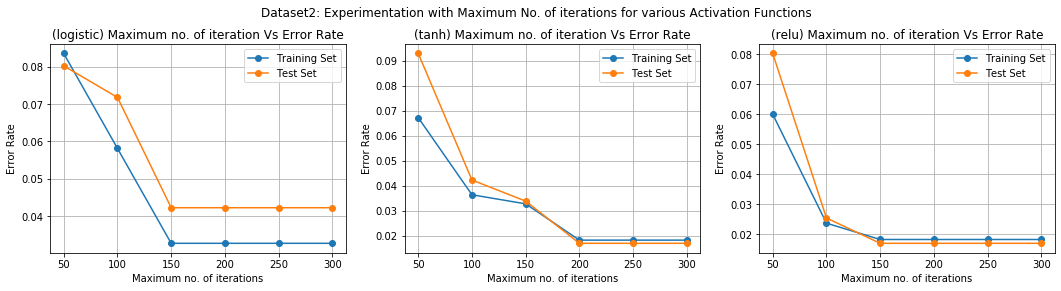

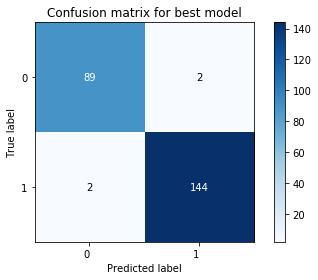

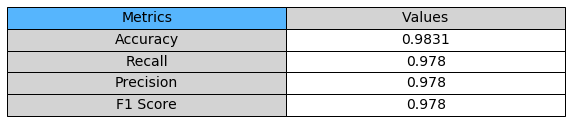

In [46]:
fig_d2_ex11_2, ax_d2_ex11_2 = plt.subplots(ncols=3, nrows=1, figsize=(18,4))

ax_d2_ex11_2[0].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['logistic'], 'o-', label='Training Set')
ax_d2_ex11_2[0].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['logistic'], 'o-', label='Test Set')
ax_d2_ex11_2[0].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(logistic) Maximum no. of iteration Vs Error Rate')
ax_d2_ex11_2[0].grid()
ax_d2_ex11_2[0].legend(loc='best')

ax_d2_ex11_2[1].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['tanh'], 'o-', label='Training Set')
ax_d2_ex11_2[1].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['tanh'], 'o-', label='Test Set')
ax_d2_ex11_2[1].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(tanh) Maximum no. of iteration Vs Error Rate')
ax_d2_ex11_2[1].grid()
ax_d2_ex11_2[1].legend(loc='best')

ax_d2_ex11_2[2].plot(d2_ex11_maxiter, d2_ex11_train_err_matrix['relu'], 'o-', label='Training Set')
ax_d2_ex11_2[2].plot(d2_ex11_maxiter, d2_ex11_test_err_matrix['relu'], 'o-', label='Test Set')
ax_d2_ex11_2[2].set(xlabel='Maximum no. of iterations', ylabel='Error Rate', title='(relu) Maximum no. of iteration Vs Error Rate')
ax_d2_ex11_2[2].grid()
ax_d2_ex11_2[2].legend(loc='best')

fig_d2_ex11_2.suptitle('Dataset2: Experimentation with Maximum No. of iterations for various Activation Functions')
fig_d2_ex11_2.subplots_adjust(top=0.85)

# Best model is for activation function = 'relu', maximum iterations = 150
d2_ex11_nn_2_mod = neural(d2_train_x, d2_train_y, 'relu', n_hidden_layer_size, 150, n_learning_rate)
plot_confusion_matrix(d2_test_y, d2_ex11_nn_2_mod.predict(d2_test_x), classes=set(d2_train_y))

**Experiment 1.2 - Experimentation using Hidden layer sizes and Number of nodes**

_Dataset 1: Energy Data_

In [47]:
d1_ex13_2_nodes = [60,70,80,90,100]
d1_ex13_2_nodes = [50,100,150,200,250,300]
d1_ex13_2_layers = [1,2,3,4,5]
d1_ex13_2_train_acc_matrix = {}
d1_ex13_2_train_err_matrix = {}
d1_ex13_2_test_acc_matrix = {}
d1_ex13_2_test_err_matrix = {}

for l in d1_ex13_2_layers:
    d1_ex13_2_train_acc = []
    d1_ex13_2_train_err = []
    d1_ex13_2_test_acc = []
    d1_ex13_2_test_err = []
    for n in d1_ex13_2_nodes:
        d1_ex13_2_nn_mod = neural(d1_train_x, d1_train_y, 'tanh', l*[n], 0, n_learning_rate)
        d1_ex13_2_train_acc.append(d1_ex13_2_nn_mod.score(d1_train_x,d1_train_y))
        d1_ex13_2_train_err.append(1-d1_ex13_2_nn_mod.score(d1_train_x, d1_train_y))
        d1_ex13_2_test_acc.append(d1_ex13_2_nn_mod.score(d1_test_x,d1_test_y))
        d1_ex13_2_test_err.append(1-d1_ex13_2_nn_mod.score(d1_test_x,d1_test_y))
    d1_ex13_2_train_acc_matrix[l] = d1_ex13_2_train_acc
    d1_ex13_2_train_err_matrix[l] = d1_ex13_2_train_err
    d1_ex13_2_test_acc_matrix[l] = d1_ex13_2_test_acc
    d1_ex13_2_test_err_matrix[l] = d1_ex13_2_test_err

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

(<matplotlib.axes._subplots.AxesSubplot at 0x18ab2c8a828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18ab2d91e10>)

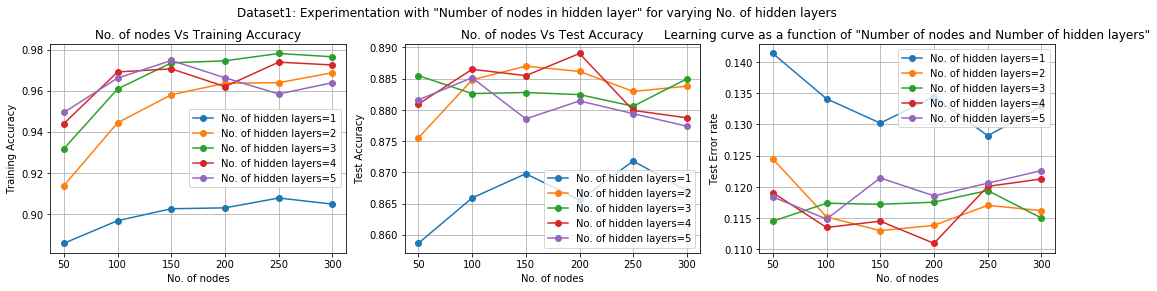

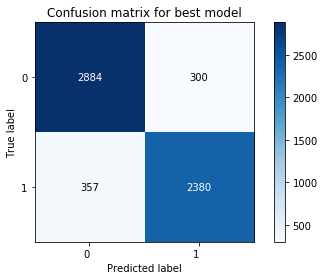

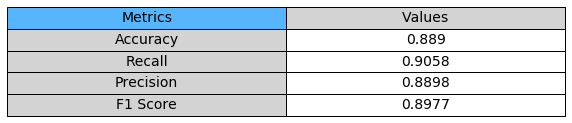

In [48]:
fig_d1_ex13_2, ax_d1_ex13_2 = plt.subplots(ncols=3, nrows=1, figsize=(18,4))

ax_d1_ex13_2[0].plot(d1_ex13_2_nodes, d1_ex13_2_train_acc_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d1_ex13_2[0].plot(d1_ex13_2_nodes, d1_ex13_2_train_acc_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d1_ex13_2[0].plot(d1_ex13_2_nodes, d1_ex13_2_train_acc_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d1_ex13_2[0].plot(d1_ex13_2_nodes, d1_ex13_2_train_acc_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d1_ex13_2[0].plot(d1_ex13_2_nodes, d1_ex13_2_train_acc_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d1_ex13_2[0].set(xlabel='No. of nodes', ylabel='Training Accuracy', title='No. of nodes Vs Training Accuracy')
ax_d1_ex13_2[0].grid()
ax_d1_ex13_2[0].legend(loc='best')


ax_d1_ex13_2[1].plot(d1_ex13_2_nodes, d1_ex13_2_test_acc_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d1_ex13_2[1].plot(d1_ex13_2_nodes, d1_ex13_2_test_acc_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d1_ex13_2[1].plot(d1_ex13_2_nodes, d1_ex13_2_test_acc_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d1_ex13_2[1].plot(d1_ex13_2_nodes, d1_ex13_2_test_acc_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d1_ex13_2[1].plot(d1_ex13_2_nodes, d1_ex13_2_test_acc_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d1_ex13_2[1].set(xlabel='No. of nodes', ylabel='Test Accuracy', title='No. of nodes Vs Test Accuracy')
ax_d1_ex13_2[1].grid()
ax_d1_ex13_2[1].legend(loc='best')

ax_d1_ex13_2[2].plot(d1_ex13_2_nodes, d1_ex13_2_test_err_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d1_ex13_2[2].plot(d1_ex13_2_nodes, d1_ex13_2_test_err_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d1_ex13_2[2].plot(d1_ex13_2_nodes, d1_ex13_2_test_err_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d1_ex13_2[2].plot(d1_ex13_2_nodes, d1_ex13_2_test_err_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d1_ex13_2[2].plot(d1_ex13_2_nodes, d1_ex13_2_test_err_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d1_ex13_2[2].set(xlabel='No. of nodes', ylabel='Test Error rate', title='Learning curve as a function of "Number of nodes and Number of hidden layers"')
ax_d1_ex13_2[2].grid()
ax_d1_ex13_2[2].legend(loc='best')

fig_d1_ex13_2.suptitle('Dataset1: Experimentation with "Number of nodes in hidden layer" for varying No. of hidden layers')
fig_d1_ex13_2.subplots_adjust(top=0.85)

# Best model is for activation function = 'tanh', maximum iterations = 600
d1_ex13_nn_2_mod = neural(d1_train_x, d1_train_y, 'tanh', [200,200,200,200], 600, n_learning_rate)
plot_confusion_matrix(d1_test_y, d1_ex13_nn_2_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [49]:
d2_ex13_2_nodes = [60,70,80,90,100]
d2_ex13_2_nodes = [50,100,150,200,250,300]
d2_ex13_2_layers = [1,2,3,4,5]
d2_ex13_2_train_acc_matrix = {}
d2_ex13_2_train_err_matrix = {}
d2_ex13_2_test_acc_matrix = {}
d2_ex13_2_test_err_matrix = {}

for l in d2_ex13_2_layers:
    d2_ex13_2_train_acc = []
    d2_ex13_2_train_err = []
    d2_ex13_2_test_acc = []
    d2_ex13_2_test_err = []
    for n in d2_ex13_2_nodes:
        d2_ex13_2_nn_mod = neural(d2_train_x, d2_train_y, 'relu', l*[n], 0, n_learning_rate)
        d2_ex13_2_train_acc.append(d2_ex13_2_nn_mod.score(d2_train_x,d2_train_y))
        d2_ex13_2_train_err.append(1-d2_ex13_2_nn_mod.score(d2_train_x, d2_train_y))
        d2_ex13_2_test_acc.append(d2_ex13_2_nn_mod.score(d2_test_x,d2_test_y))
        d2_ex13_2_test_err.append(1-d2_ex13_2_nn_mod.score(d2_test_x,d2_test_y))
    d2_ex13_2_train_acc_matrix[l] = d2_ex13_2_train_acc
    d2_ex13_2_train_err_matrix[l] = d2_ex13_2_train_err
    d2_ex13_2_test_acc_matrix[l] = d2_ex13_2_test_acc
    d2_ex13_2_test_err_matrix[l] = d2_ex13_2_test_err

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8c296d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8ada05f8>)

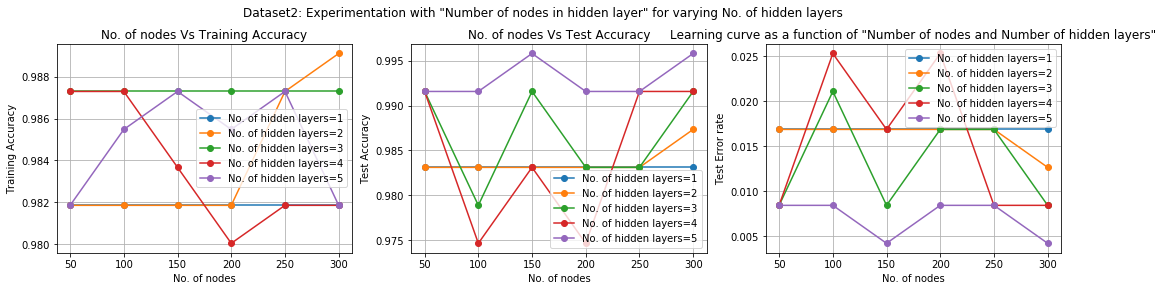

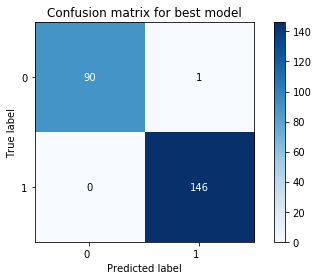

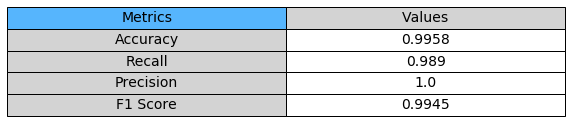

In [50]:
fig_d2_ex13_2, ax_d2_ex13_2 = plt.subplots(ncols=3, nrows=1, figsize=(18,4))

ax_d2_ex13_2[0].plot(d2_ex13_2_nodes, d2_ex13_2_train_acc_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d2_ex13_2[0].plot(d2_ex13_2_nodes, d2_ex13_2_train_acc_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d2_ex13_2[0].plot(d2_ex13_2_nodes, d2_ex13_2_train_acc_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d2_ex13_2[0].plot(d2_ex13_2_nodes, d2_ex13_2_train_acc_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d2_ex13_2[0].plot(d2_ex13_2_nodes, d2_ex13_2_train_acc_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d2_ex13_2[0].set(xlabel='No. of nodes', ylabel='Training Accuracy', title='No. of nodes Vs Training Accuracy')
ax_d2_ex13_2[0].grid()
ax_d2_ex13_2[0].legend(loc='best')


ax_d2_ex13_2[1].plot(d2_ex13_2_nodes, d2_ex13_2_test_acc_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d2_ex13_2[1].plot(d2_ex13_2_nodes, d2_ex13_2_test_acc_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d2_ex13_2[1].plot(d2_ex13_2_nodes, d2_ex13_2_test_acc_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d2_ex13_2[1].plot(d2_ex13_2_nodes, d2_ex13_2_test_acc_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d2_ex13_2[1].plot(d2_ex13_2_nodes, d2_ex13_2_test_acc_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d2_ex13_2[1].set(xlabel='No. of nodes', ylabel='Test Accuracy', title='No. of nodes Vs Test Accuracy')
ax_d2_ex13_2[1].grid()
ax_d2_ex13_2[1].legend(loc='best')

ax_d2_ex13_2[2].plot(d2_ex13_2_nodes, d2_ex13_2_test_err_matrix[1], 'o-', label='No. of hidden layers=1')
ax_d2_ex13_2[2].plot(d2_ex13_2_nodes, d2_ex13_2_test_err_matrix[2], 'o-', label='No. of hidden layers=2')
ax_d2_ex13_2[2].plot(d2_ex13_2_nodes, d2_ex13_2_test_err_matrix[3], 'o-', label='No. of hidden layers=3')
ax_d2_ex13_2[2].plot(d2_ex13_2_nodes, d2_ex13_2_test_err_matrix[4], 'o-', label='No. of hidden layers=4')
ax_d2_ex13_2[2].plot(d2_ex13_2_nodes, d2_ex13_2_test_err_matrix[5], 'o-', label='No. of hidden layers=5')
ax_d2_ex13_2[2].set(xlabel='No. of nodes', ylabel='Test Error rate', title='Learning curve as a function of "Number of nodes and Number of hidden layers"')
ax_d2_ex13_2[2].grid()
ax_d2_ex13_2[2].legend(loc='best')

fig_d2_ex13_2.suptitle('Dataset2: Experimentation with "Number of nodes in hidden layer" for varying No. of hidden layers')
fig_d2_ex13_2.subplots_adjust(top=0.85)

# Best model is for activation function = 'tanh', maximum iterations = 600
d2_ex13_nn_2_mod = neural(d2_train_x, d2_train_y, 'relu', [300,300,300,300,300], 0, n_learning_rate)
plot_confusion_matrix(d2_test_y, d2_ex13_nn_2_mod.predict(d2_test_x), classes=set(d2_train_y))

**Experiment 1.3 - Experimentation with Training Size**

_Dataset1: Energy Data_

In [51]:
d1_ex14_size = [0.6,0.7,0.8,0.9,1.0]
d1_ex14_train_acc = []
d1_ex14_test_acc = []
d1_ex14_train_err = []
d1_ex14_test_err = []

for s in d1_ex14_size:
    num = round(s*d1_train_x.shape[0])
    d1_ex14_nn_mod = neural(d1_train_x.loc[:num], d1_train_y.loc[:num], 'tanh', n_hidden_layer_size, 600, n_learning_rate)
    d1_ex14_train_acc.append(d1_ex14_nn_mod.score(d1_train_x.loc[:num], d1_train_y.loc[:num]))
    d1_ex14_train_err.append(1-d1_ex14_nn_mod.score(d1_train_x.loc[:num], d1_train_y.loc[:num]))
    d1_ex14_test_acc.append(d1_ex14_nn_mod.score(d1_test_x, d1_test_y))
    d1_ex14_test_err.append(1-d1_ex14_nn_mod.score(d1_test_x, d1_test_y))

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x18a90caebe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a9227f5c0>)

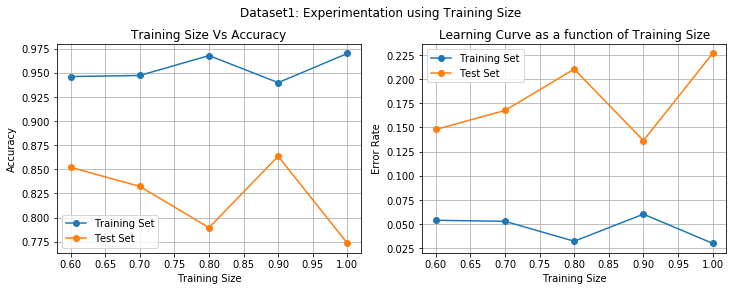

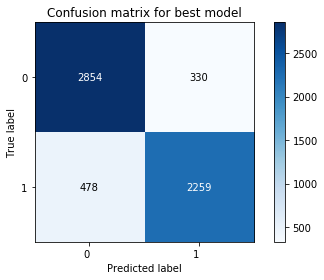

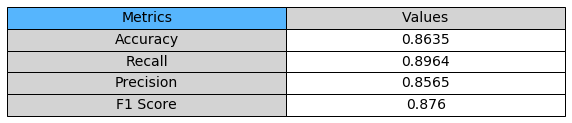

In [80]:
fig_d1_ex14, ax_d1_ex14 = plt.subplots(ncols=2,nrows=1, figsize=(12,4))

ax_d1_ex14[0].plot(d1_ex14_size, d1_ex14_train_acc, 'o-', label='Training Set')
ax_d1_ex14[0].plot(d1_ex14_size, d1_ex14_test_acc, 'o-', label='Test Set')
ax_d1_ex14[0].set(xlabel='Training Size', ylabel='Accuracy', title='Training Size Vs Accuracy')
ax_d1_ex14[0].grid()
ax_d1_ex14[0].legend(loc='best')

ax_d1_ex14[1].plot(d1_ex14_size, d1_ex14_train_err, 'o-', label='Training Set')
ax_d1_ex14[1].plot(d1_ex14_size, d1_ex14_test_err, 'o-', label='Test Set')
ax_d1_ex14[1].set(xlabel='Training Size', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_d1_ex14[1].grid()
ax_d1_ex14[1].legend(loc='best')

fig_d1_ex14.suptitle('Dataset1: Experimentation using Training Size')
fig_d1_ex14.subplots_adjust(top=0.85)

# Best model is for training size = 0.9
num14 = round(0.9*d1_train_x.shape[0])
d1_ex14_nn_2_mod = neural(d1_train_x.loc[:num14], d1_train_y.loc[:num14], 'tanh', n_hidden_layer_size, 600, n_learning_rate)
plot_confusion_matrix(d1_test_y, d1_ex14_nn_2_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [53]:
d2_ex14_size = [0.6,0.7,0.8,0.9,1.0]
d2_ex14_train_acc = []
d2_ex14_test_acc = []
d2_ex14_train_err = []
d2_ex14_test_err = []

for s in d2_ex14_size:
    num = round(s*d2_train_x.shape[0])-1
    d2_ex14_nn_mod = neural(d2_train_x.loc[:num], d2_train_y.loc[:num], 'relu', n_hidden_layer_size, 0, n_learning_rate)
    d2_ex14_train_acc.append(d2_ex14_nn_mod.score(d2_train_x.loc[:num], d2_train_y.loc[:num]))
    d2_ex14_train_err.append(1-d2_ex14_nn_mod.score(d2_train_x.loc[:num], d2_train_y.loc[:num]))
    d2_ex14_test_acc.append(d2_ex14_nn_mod.score(d2_test_x, d2_test_y))
    d2_ex14_test_err.append(1-d2_ex14_nn_mod.score(d2_test_x, d2_test_y))

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\adir0\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x18a8c111c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8ad43da0>)

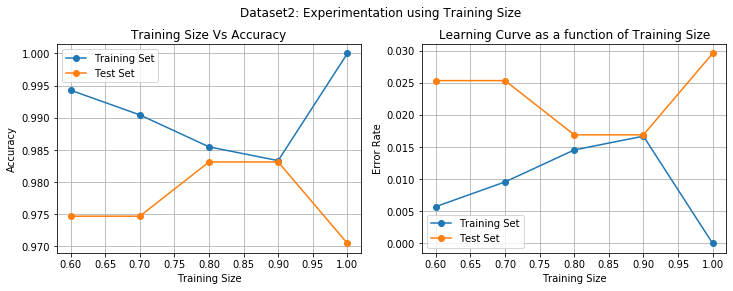

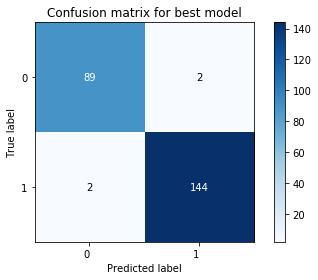

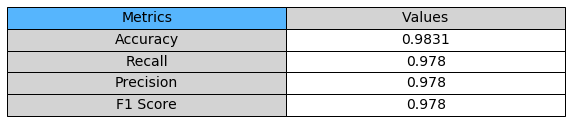

In [54]:
fig_d2_ex14, ax_d2_ex14 = plt.subplots(ncols=2,nrows=1, figsize=(12,4))

ax_d2_ex14[0].plot(d2_ex14_size, d2_ex14_train_acc, 'o-', label='Training Set')
ax_d2_ex14[0].plot(d2_ex14_size, d2_ex14_test_acc, 'o-', label='Test Set')
ax_d2_ex14[0].set(xlabel='Training Size', ylabel='Accuracy', title='Training Size Vs Accuracy')
ax_d2_ex14[0].grid()
ax_d2_ex14[0].legend(loc='best')

ax_d2_ex14[1].plot(d2_ex14_size, d2_ex14_train_err, 'o-', label='Training Set')
ax_d2_ex14[1].plot(d2_ex14_size, d2_ex14_test_err, 'o-', label='Test Set')
ax_d2_ex14[1].set(xlabel='Training Size', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_d2_ex14[1].grid()
ax_d2_ex14[1].legend(loc='best')

fig_d2_ex14.suptitle('Dataset2: Experimentation using Training Size')
fig_d2_ex14.subplots_adjust(top=0.85)

# Best model is for training size = 0.9
num14 = round(0.9*d2_train_x.shape[0])-1
d2_ex14_nn_2_mod = neural(d2_train_x.loc[:num14], d2_train_y.loc[:num14], 'relu', n_hidden_layer_size, 0, n_learning_rate)
plot_confusion_matrix(d2_test_y, d2_ex14_nn_2_mod.predict(d2_test_x), classes=set(d2_train_y))

**TASK 2 - K-Nearest Nighbours**

In [55]:
#KNN model definition
from sklearn.neighbors import KNeighborsClassifier

def knn(X, Y, algorith, k, w, power):
    knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorith, weights = w, p = power)
    knn_mod.fit(X, Y)
    return(knn_mod)

In [56]:
d1_power = 2
d1_k = 5
d1_weights = 'uniform' 

In [57]:
#knn(d1_train_x, d1_train_y, 'brute', d1_k, d1_weights, d1_power).score(d1_test_x, d1_test_y)

#knn.score(d1_test_x, d1_test_y)

**Experiment 2.1 - Analysis of Brute force, K-dimensional Tree and BallTree algorithms**

_Dataset 1: Energy Data_

In [58]:
import time
algorithms = ['brute', 'kd_tree', 'ball_tree']
d1_ex21_k = [5,10,15,20,25,30]
d1_ex21_train_acc = {}
d1_ex21_test_acc = {}
d1_ex21_train_err = {}
d1_ex21_test_err = {}
d1_ex21_clocktime = {}

for a in algorithms:
    d1_ex21_train_acc_matrix = []
    d1_ex21_test_acc_matrix = []
    d1_ex21_train_err_matrix = []
    d1_ex21_test_err_matrix = []
    d1_ex21_clock_matrix = []
    for k2 in d1_ex21_k:
        d1_ex21_start = time.time()
        d1_ex21_knn_mod = knn(d1_train_x, d1_train_y, a, k2, d1_weights, d1_power)
        d1_ex21_stop = time.time()
        #print(d1_ex21_knn_mod)
        d1_ex21_clock_matrix.append(d1_ex21_stop-d1_ex21_start)
        d1_ex21_train_acc_matrix.append(d1_ex21_knn_mod.score(d1_train_x, d1_train_y))
        d1_ex21_train_err_matrix.append(1-d1_ex21_knn_mod.score(d1_train_x, d1_train_y))
        d1_ex21_test_acc_matrix.append(d1_ex21_knn_mod.score(d1_test_x, d1_test_y))
        d1_ex21_test_err_matrix.append(1-d1_ex21_knn_mod.score(d1_test_x, d1_test_y))
    d1_ex21_clocktime[a] = d1_ex21_clock_matrix
    d1_ex21_train_acc[a] = d1_ex21_train_acc_matrix
    d1_ex21_train_err[a] = d1_ex21_train_err_matrix
    d1_ex21_test_acc[a] = d1_ex21_test_acc_matrix
    d1_ex21_test_err[a] = d1_ex21_test_err_matrix   

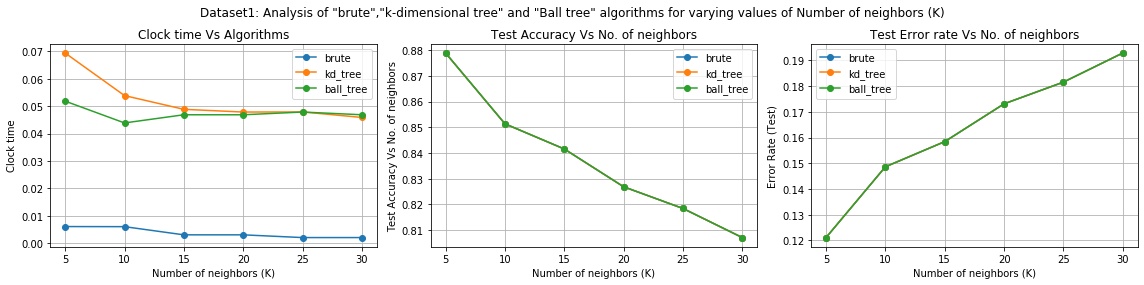

In [59]:
d1_ex21_fig1, d1_ex21_ax1 = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

d1_ex21_ax1[0].plot(d1_ex21_k, d1_ex21_clocktime['brute'], 'o-', label='brute')
d1_ex21_ax1[0].plot(d1_ex21_k, d1_ex21_clocktime['kd_tree'], 'o-', label='kd_tree')
d1_ex21_ax1[0].plot(d1_ex21_k, d1_ex21_clocktime['ball_tree'], 'o-', label='ball_tree')
d1_ex21_ax1[0].set(xlabel='Number of neighbors (K)', ylabel='Clock time', title='Clock time Vs Algorithms')
d1_ex21_ax1[0].grid()
d1_ex21_ax1[0].legend(loc='best')

d1_ex21_ax1[1].plot(d1_ex21_k, d1_ex21_test_acc['brute'], 'o-', label='brute')
d1_ex21_ax1[1].plot(d1_ex21_k, d1_ex21_test_acc['kd_tree'], 'o-', label='kd_tree')
d1_ex21_ax1[1].plot(d1_ex21_k, d1_ex21_test_acc['ball_tree'], 'o-', label='ball_tree')
d1_ex21_ax1[1].set(xlabel='Number of neighbors (K)', ylabel='Test Accuracy Vs No. of neighbors', title='Test Accuracy Vs No. of neighbors')
d1_ex21_ax1[1].grid()
d1_ex21_ax1[1].legend(loc='best')

d1_ex21_ax1[2].plot(d1_ex21_k, d1_ex21_test_err['brute'], 'o-', label='brute')
d1_ex21_ax1[2].plot(d1_ex21_k, d1_ex21_test_err['kd_tree'], 'o-', label='kd_tree')
d1_ex21_ax1[2].plot(d1_ex21_k, d1_ex21_test_err['ball_tree'], 'o-', label='ball_tree')
d1_ex21_ax1[2].set(xlabel='Number of neighbors (K)', ylabel='Error Rate (Test)', title='Test Error rate Vs No. of neighbors')
d1_ex21_ax1[2].grid()
d1_ex21_ax1[2].legend(loc='best')

d1_ex21_fig1.suptitle('Dataset1: Analysis of "brute","k-dimensional tree" and "Ball tree" algorithms for varying values of Number of neighbors (K)')
d1_ex21_fig1.tight_layout()
d1_ex21_fig1.subplots_adjust(top=0.85)

In [60]:
d1_ex21_2_train_err = []
d1_ex21_2_test_err = []

for k2 in range(1,10):
    d1_ex21_2_knn_mod = knn(d1_train_x, d1_train_y, 'brute', k2, d1_weights, d1_power)
    d1_ex21_2_train_err.append(1-d1_ex21_2_knn_mod.score(d1_train_x, d1_train_y))
    d1_ex21_2_test_err.append(1-d1_ex21_2_knn_mod.score(d1_test_x, d1_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8c057be0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8c476e48>)

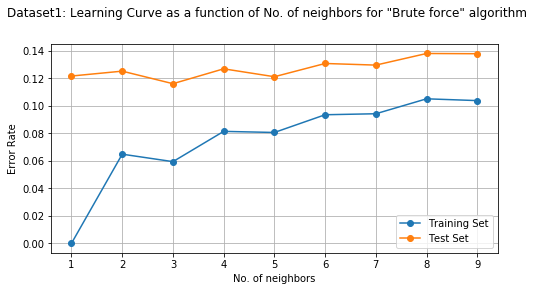

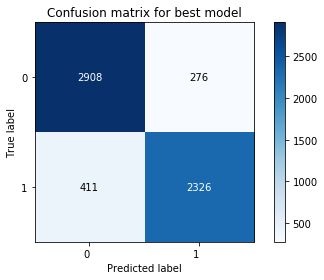

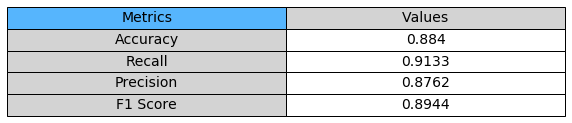

In [61]:
fig_d1_ex21_2, ax_d1_ex21_2 = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
ax_d1_ex21_2.plot(range(1,10), d1_ex21_2_train_err, 'o-', label='Training Set')
ax_d1_ex21_2.plot(range(1,10), d1_ex21_2_test_err, 'o-', label='Test Set')
ax_d1_ex21_2.set(xlabel='No. of neighbors', ylabel='Error Rate')
ax_d1_ex21_2.grid()
ax_d1_ex21_2.legend(loc='best')

fig_d1_ex21_2.suptitle('Dataset1: Learning Curve as a function of No. of neighbors for "Brute force" algorithm')
fig_d1_ex21_2.subplots_adjust(top=0.85)

# Best model is for k = 3, algorithm = 'brute force'
d1_ex21_2_mod = knn(d1_train_x, d1_train_y, 'brute', 3, d1_weights, d1_power)
plot_confusion_matrix(d1_test_y, d1_ex21_2_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [62]:
import time
algorithms = ['brute', 'kd_tree', 'ball_tree']
d2_ex21_k = [5,10,15,20,25,30]
d2_ex21_train_acc = {}
d2_ex21_test_acc = {}
d2_ex21_train_err = {}
d2_ex21_test_err = {}
d2_ex21_clocktime = {}

for a in algorithms:
    d2_ex21_train_acc_matrix = []
    d2_ex21_test_acc_matrix = []
    d2_ex21_train_err_matrix = []
    d2_ex21_test_err_matrix = []
    d2_ex21_clock_matrix = []
    for k2 in d2_ex21_k:
        d2_ex21_start = time.time()
        d2_ex21_knn_mod = knn(d2_train_x, d2_train_y, a, k2, d1_weights, d1_power)
        d2_ex21_stop = time.time()
        #print(d2_ex21_knn_mod)
        d2_ex21_clock_matrix.append(d2_ex21_stop-d2_ex21_start)
        d2_ex21_train_acc_matrix.append(d2_ex21_knn_mod.score(d2_train_x, d2_train_y))
        d2_ex21_train_err_matrix.append(1-d2_ex21_knn_mod.score(d2_train_x, d2_train_y))
        d2_ex21_test_acc_matrix.append(d2_ex21_knn_mod.score(d2_test_x, d2_test_y))
        d2_ex21_test_err_matrix.append(1-d2_ex21_knn_mod.score(d2_test_x, d2_test_y))
    d2_ex21_clocktime[a] = d2_ex21_clock_matrix
    d2_ex21_train_acc[a] = d2_ex21_train_acc_matrix
    d2_ex21_train_err[a] = d2_ex21_train_err_matrix
    d2_ex21_test_acc[a] = d2_ex21_test_acc_matrix
    d2_ex21_test_err[a] = d2_ex21_test_err_matrix   

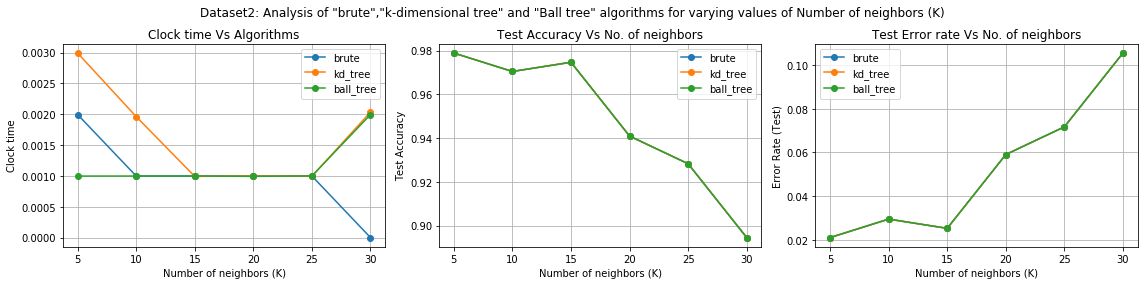

In [63]:
d2_ex21_fig1, d2_ex21_ax1 = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

d2_ex21_ax1[0].plot(d2_ex21_k, d2_ex21_clocktime['brute'], 'o-', label='brute')
d2_ex21_ax1[0].plot(d2_ex21_k, d2_ex21_clocktime['kd_tree'], 'o-', label='kd_tree')
d2_ex21_ax1[0].plot(d2_ex21_k, d2_ex21_clocktime['ball_tree'], 'o-', label='ball_tree')
d2_ex21_ax1[0].set(xlabel='Number of neighbors (K)', ylabel='Clock time', title='Clock time Vs Algorithms')
d2_ex21_ax1[0].grid()
d2_ex21_ax1[0].legend(loc='best')

d2_ex21_ax1[1].plot(d2_ex21_k, d2_ex21_test_acc['brute'], 'o-', label='brute')
d2_ex21_ax1[1].plot(d2_ex21_k, d2_ex21_test_acc['kd_tree'], 'o-', label='kd_tree')
d2_ex21_ax1[1].plot(d2_ex21_k, d2_ex21_test_acc['ball_tree'], 'o-', label='ball_tree')
d2_ex21_ax1[1].set(xlabel='Number of neighbors (K)', ylabel='Test Accuracy', title='Test Accuracy Vs No. of neighbors')
d2_ex21_ax1[1].grid()
d2_ex21_ax1[1].legend(loc='best')

d2_ex21_ax1[2].plot(d2_ex21_k, d2_ex21_test_err['brute'], 'o-', label='brute')
d2_ex21_ax1[2].plot(d2_ex21_k, d2_ex21_test_err['kd_tree'], 'o-', label='kd_tree')
d2_ex21_ax1[2].plot(d2_ex21_k, d2_ex21_test_err['ball_tree'], 'o-', label='ball_tree')
d2_ex21_ax1[2].set(xlabel='Number of neighbors (K)', ylabel='Error Rate (Test)', title='Test Error rate Vs No. of neighbors')
d2_ex21_ax1[2].grid()
d2_ex21_ax1[2].legend(loc='best')

d2_ex21_fig1.suptitle('Dataset2: Analysis of "brute","k-dimensional tree" and "Ball tree" algorithms for varying values of Number of neighbors (K)')
d2_ex21_fig1.tight_layout()
d2_ex21_fig1.subplots_adjust(top=0.85)

In [64]:
d2_ex21_2_train_err = []
d2_ex21_2_test_err = []

for k2 in range(1,10):
    d2_ex21_2_knn_mod = knn(d2_train_x, d2_train_y, 'brute', k2, d1_weights, d1_power)
    d2_ex21_2_train_err.append(1-d2_ex21_2_knn_mod.score(d2_train_x, d2_train_y))
    d2_ex21_2_test_err.append(1-d2_ex21_2_knn_mod.score(d2_test_x, d2_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8c643a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8c620ba8>)

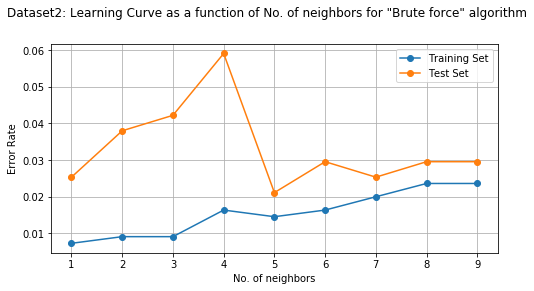

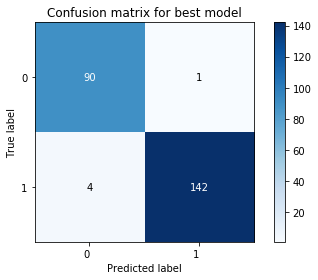

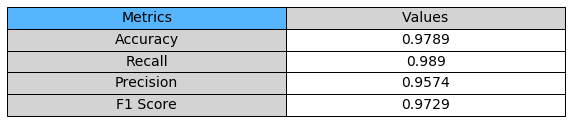

In [65]:
fig_d2_ex21_2, ax_d2_ex21_2 = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
ax_d2_ex21_2.plot(range(1,10), d2_ex21_2_train_err, 'o-', label='Training Set')
ax_d2_ex21_2.plot(range(1,10), d2_ex21_2_test_err, 'o-', label='Test Set')
ax_d2_ex21_2.set(xlabel='No. of neighbors', ylabel='Error Rate')
ax_d2_ex21_2.grid()
ax_d2_ex21_2.legend(loc='best')

fig_d2_ex21_2.suptitle('Dataset2: Learning Curve as a function of No. of neighbors for "Brute force" algorithm')
fig_d2_ex21_2.subplots_adjust(top=0.85)

# Best model is for k = 5, algorithm = 'brute force'
d2_ex21_2_mod = knn(d2_train_x, d2_train_y, 'brute', 5, d1_weights, d1_power)
plot_confusion_matrix(d2_test_y, d2_ex21_2_mod.predict(d2_test_x), classes=set(d2_train_y))

**Experiment 2.2 - Analysis of power parameter for 'Minkowski' metric (distance metric - Euclidean and Manhattan)**

_Dataset 1:Audit Data_

In [66]:
d1_ex22_power = [1,2,3]
#d1_ex22_power = [1,2]
d1_ex22_train_acc = []
d1_ex22_test_acc = []
d1_ex22_train_err = []
d1_ex22_test_err = []

for p in d1_ex22_power:
    d1_ex22_knn_mod = knn(d1_train_x, d1_train_y, 'brute', 3, d1_weights, p)
    d1_ex22_train_acc.append(d1_ex22_knn_mod.score(d1_train_x, d1_train_y))
    d1_ex22_train_err.append(1-d1_ex22_knn_mod.score(d1_train_x, d1_train_y))
    d1_ex22_test_acc.append(d1_ex22_knn_mod.score(d1_test_x, d1_test_y))
    d1_ex22_test_err.append(1-d1_ex22_knn_mod.score(d1_test_x, d1_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8f2fe128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8b7a4898>)

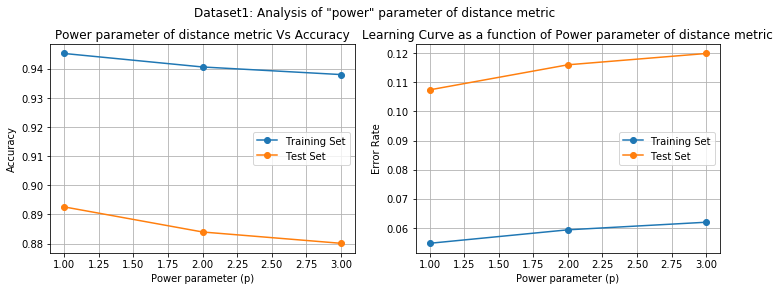

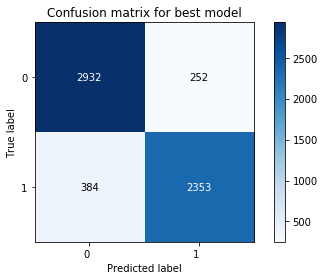

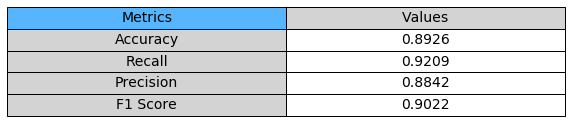

In [67]:
d1_ex22_fig1, d1_ex22_ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

d1_ex22_ax1[0].plot(d1_ex22_power, d1_ex22_train_acc, 'o-', label='Training Set')
d1_ex22_ax1[0].plot(d1_ex22_power, d1_ex22_test_acc, 'o-', label='Test Set')
d1_ex22_ax1[0].set(xlabel='Power parameter (p)', ylabel='Accuracy', title='Power parameter of distance metric Vs Accuracy')
d1_ex22_ax1[0].grid()
d1_ex22_ax1[0].legend(loc='best')

d1_ex22_ax1[1].plot(d1_ex22_power, d1_ex22_train_err, 'o-', label='Training Set')
d1_ex22_ax1[1].plot(d1_ex22_power, d1_ex22_test_err, 'o-', label='Test Set')
d1_ex22_ax1[1].set(xlabel='Power parameter (p)', ylabel='Error Rate', title='Learning Curve as a function of Power parameter of distance metric')
d1_ex22_ax1[1].grid()
d1_ex22_ax1[1].legend(loc='best')

d1_ex22_fig1.suptitle('Dataset1: Analysis of "power" parameter of distance metric')
d1_ex22_fig1.subplots_adjust(top=0.85)

# Best model is for k = 3, algorithm = 'brute force', power = 1
d1_ex22_2_mod = knn(d1_train_x, d1_train_y, 'brute', 3, d1_weights, 1)
plot_confusion_matrix(d1_test_y, d1_ex22_2_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [68]:
d2_ex22_power = [1,2,3]
d2_ex22_train_acc = []
d2_ex22_test_acc = []
d2_ex22_train_err = []
d2_ex22_test_err = []

for p in d2_ex22_power:
    d2_ex22_knn_mod = knn(d2_train_x, d2_train_y, 'brute', 5, d1_weights, p)
    d2_ex22_train_acc.append(d2_ex22_knn_mod.score(d2_train_x, d2_train_y))
    d2_ex22_train_err.append(1-d2_ex22_knn_mod.score(d2_train_x, d2_train_y))
    d2_ex22_test_acc.append(d2_ex22_knn_mod.score(d2_test_x, d2_test_y))
    d2_ex22_test_err.append(1-d2_ex22_knn_mod.score(d2_test_x, d2_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8dfde160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8c772dd8>)

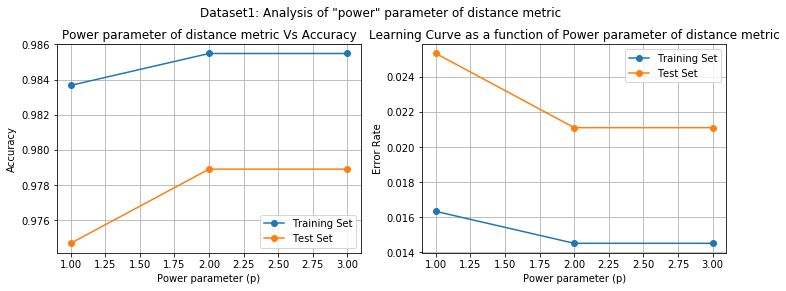

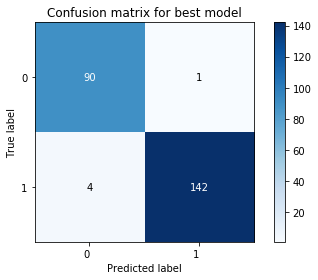

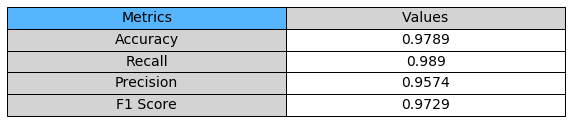

In [69]:
d2_ex22_fig1, d2_ex22_ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

d2_ex22_ax1[0].plot(d2_ex22_power, d2_ex22_train_acc, 'o-', label='Training Set')
d2_ex22_ax1[0].plot(d2_ex22_power, d2_ex22_test_acc, 'o-', label='Test Set')
d2_ex22_ax1[0].set(xlabel='Power parameter (p)', ylabel='Accuracy', title='Power parameter of distance metric Vs Accuracy')
d2_ex22_ax1[0].grid()
d2_ex22_ax1[0].legend(loc='best')

d2_ex22_ax1[1].plot(d2_ex22_power, d2_ex22_train_err, 'o-', label='Training Set')
d2_ex22_ax1[1].plot(d2_ex22_power, d2_ex22_test_err, 'o-', label='Test Set')
d2_ex22_ax1[1].set(xlabel='Power parameter (p)', ylabel='Error Rate', title='Learning Curve as a function of Power parameter of distance metric')
d2_ex22_ax1[1].grid()
d2_ex22_ax1[1].legend(loc='best')

d2_ex22_fig1.suptitle('Dataset2: Analysis of "power" parameter of distance metric')
d2_ex22_fig1.subplots_adjust(top=0.85)

# Best model is for k = 5, algorithm = 'brute force', power = 2
d2_ex22_2_mod = knn(d2_train_x, d2_train_y, 'brute', 5, d1_weights, 2)
plot_confusion_matrix(d2_test_y, d2_ex22_2_mod.predict(d2_test_x), classes=set(d2_train_y))

**Experiment 2.3 - Learning Curve as a function of Training Size**

_Dataset 1: Audit Data_

In [70]:
d1_ex23_size = [0.6,0.7,0.8,0.9,1.0]
d1_ex23_train_acc = []
d1_ex23_test_acc = []
d1_ex23_train_err = []
d1_ex23_test_err = []

for s in d1_ex23_size:
    num = round(s*d1_train_x.shape[0])
    d1_ex23_mod = knn(d1_train_x.loc[:num], d1_train_y.loc[:num], 'brute', 3, d1_weights, 1)
    d1_ex23_train_acc.append(d1_ex23_mod.score(d1_train_x.loc[:num], d1_train_y.loc[:num]))
    d1_ex23_train_err.append(1-d1_ex23_mod.score(d1_train_x.loc[:num], d1_train_y.loc[:num]))
    d1_ex23_test_acc.append(d1_ex23_mod.score(d1_test_x, d1_test_y))
    d1_ex23_test_err.append(1-d1_ex23_mod.score(d1_test_x, d1_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a8f1b2208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18a8f240be0>)

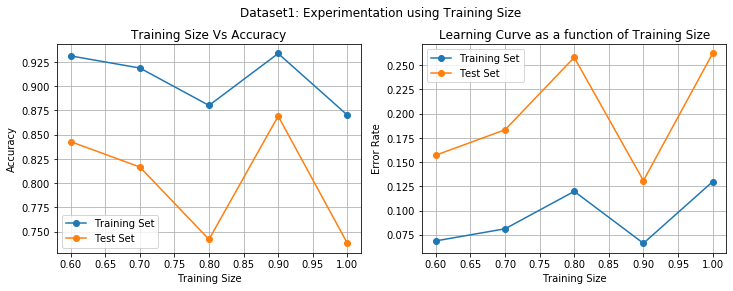

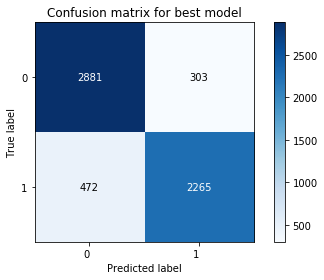

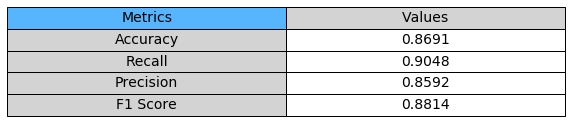

In [71]:
fig_d1_ex23, ax_d1_ex23 = plt.subplots(ncols=2,nrows=1, figsize=(12,4))

ax_d1_ex23[0].plot(d1_ex23_size, d1_ex23_train_acc, 'o-', label='Training Set')
ax_d1_ex23[0].plot(d1_ex23_size, d1_ex23_test_acc, 'o-', label='Test Set')
ax_d1_ex23[0].set(xlabel='Training Size', ylabel='Accuracy', title='Training Size Vs Accuracy')
ax_d1_ex23[0].grid()
ax_d1_ex23[0].legend(loc='best')

ax_d1_ex23[1].plot(d1_ex23_size, d1_ex23_train_err, 'o-', label='Training Set')
ax_d1_ex23[1].plot(d1_ex23_size, d1_ex23_test_err, 'o-', label='Test Set')
ax_d1_ex23[1].set(xlabel='Training Size', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_d1_ex23[1].grid()
ax_d1_ex23[1].legend(loc='best')

fig_d1_ex23.suptitle('Dataset1: Experimentation using Training Size')
fig_d1_ex23.subplots_adjust(top=0.85)

# Best model is for training size = 0.9
num23 = round(0.9*d1_train_x.shape[0])
d1_ex23_mod = knn(d1_train_x.loc[:num23], d1_train_y.loc[:num23], 'brute', 3, d1_weights, 1)
plot_confusion_matrix(d1_test_y, d1_ex23_mod.predict(d1_test_x), classes=set(d1_train_y))

_Dataset 2: Audit Data_

In [72]:
d2_ex23_size = [0.6,0.7,0.8,0.9,1.0]
d2_ex23_train_acc = []
d2_ex23_test_acc = []
d2_ex23_train_err = []
d2_ex23_test_err = []

for s in d2_ex23_size:
    num22 = round(s*d2_train_x.shape[0])-1
    d2_ex23_mod = knn(d2_train_x.loc[:num22], d2_train_y.loc[:num22], 'brute', 5, d1_weights, 2)
    d2_ex23_train_acc.append(d2_ex23_mod.score(d2_train_x.loc[:num22], d2_train_y.loc[:num22]))
    d2_ex23_train_err.append(1-d2_ex23_mod.score(d2_train_x.loc[:num22], d2_train_y.loc[:num22]))
    d2_ex23_test_acc.append(d2_ex23_mod.score(d2_test_x, d2_test_y))
    d2_ex23_test_err.append(1-d2_ex23_mod.score(d2_test_x, d2_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x18a91fee2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18ab35b57b8>)

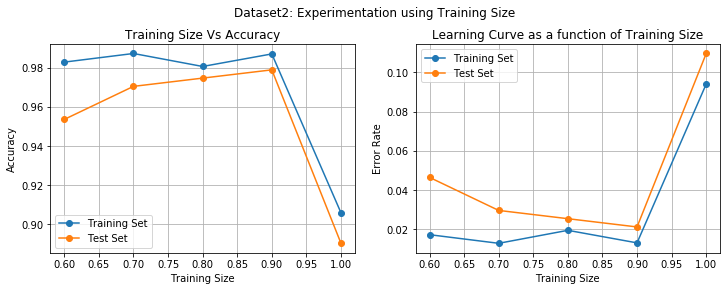

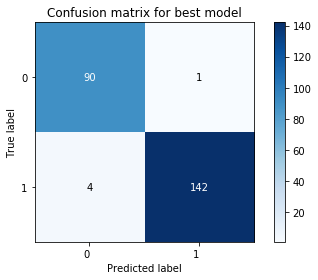

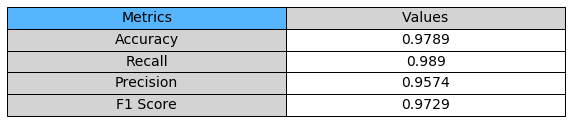

In [73]:
fig_d2_ex23, ax_d2_ex23 = plt.subplots(ncols=2,nrows=1, figsize=(12,4))

ax_d2_ex23[0].plot(d2_ex23_size, d2_ex23_train_acc, 'o-', label='Training Set')
ax_d2_ex23[0].plot(d2_ex23_size, d2_ex23_test_acc, 'o-', label='Test Set')
ax_d2_ex23[0].set(xlabel='Training Size', ylabel='Accuracy', title='Training Size Vs Accuracy')
ax_d2_ex23[0].grid()
ax_d2_ex23[0].legend(loc='best')

ax_d2_ex23[1].plot(d2_ex23_size, d2_ex23_train_err, 'o-', label='Training Set')
ax_d2_ex23[1].plot(d2_ex23_size, d2_ex23_test_err, 'o-', label='Test Set')
ax_d2_ex23[1].set(xlabel='Training Size', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_d2_ex23[1].grid()
ax_d2_ex23[1].legend(loc='best')

fig_d2_ex23.suptitle('Dataset2: Experimentation using Training Size')
fig_d2_ex23.subplots_adjust(top=0.85)

# Best model is for training size = 0.9
num223 = round(0.9*d2_train_x.shape[0])-1
d2_ex23_mod = knn(d2_train_x.loc[:num223], d2_train_y.loc[:num223], 'brute', 5, d1_weights, 2)
plot_confusion_matrix(d2_test_y, d2_ex23_mod.predict(d2_test_x), classes=set(d2_train_y))

**Cross Validation for both datasets**

In [74]:
# Cross Validation function
from sklearn.model_selection import cross_validate

def CV(model,x,Y,folds):
    cv_results = cross_validate(model,x,Y,cv=folds, return_train_score = True)
    return(cv_results)

In [75]:
folds = 5

_Dataset 1: Energy Data_

In [76]:
d1_nn = neural(d1_train_x, d1_train_y, 'tanh', [200,200,200,200], 600, n_learning_rate)
d1_cv_nn = CV(d1_nn, d1_train_x, d1_train_y, folds)

d1_knn = knn(d1_train_x, d1_train_y, 'brute', 3, d1_weights, 1)
d1_cv_knn = CV(d1_knn, d1_train_x, d1_train_y, folds)

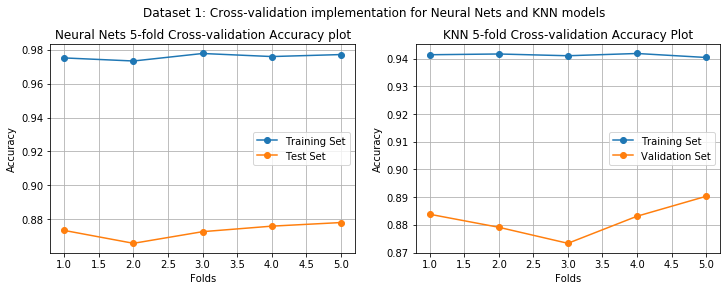

In [77]:
fig_cv1, ax_cv1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
cv_x = range(1,6)

ax_cv1[0].plot(cv_x, d1_cv_nn['train_score'], 'o-',label='Training Set')
ax_cv1[0].plot(cv_x, d1_cv_nn['test_score'], 'o-', label='Test Set')
ax_cv1[0].set(xlabel='Folds',ylabel='Accuracy',title='Neural Nets 5-fold Cross-validation Accuracy plot')
ax_cv1[0].grid()
ax_cv1[0].legend(loc='best')

ax_cv1[1].plot(cv_x, d1_cv_knn['train_score'], 'o-', label='Training Set')
ax_cv1[1].plot(cv_x, d1_cv_knn['test_score'], 'o-', label='Validation Set')
ax_cv1[1].set(xlabel='Folds',ylabel='Accuracy',title='KNN 5-fold Cross-validation Accuracy Plot')
ax_cv1[1].grid()
ax_cv1[1].legend(loc='best')

fig_cv1.suptitle('Dataset 1: Cross-validation implementation for Neural Nets and KNN models')
fig_cv1.subplots_adjust(top=0.85)

_Dataset 2: Audit Data_

In [78]:
d2_nn = neural(d2_train_x, d2_train_y, 'relu', [300,300,300,300,300], 0, n_learning_rate)
d2_cv_nn = CV(d2_nn, d2_train_x, d2_train_y, folds)

d2_knn = knn(d2_train_x, d2_train_y, 'brute', 5, d1_weights, 2)
d2_cv_knn = CV(d2_knn, d2_train_x, d2_train_y, folds)

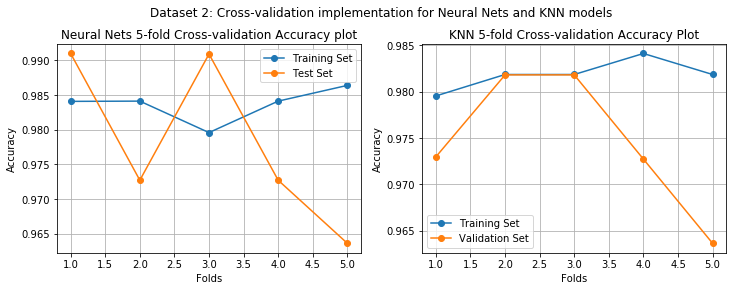

In [79]:
fig_cv2, ax_cv2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
cv_x = range(1,6)

ax_cv2[0].plot(cv_x, d2_cv_nn['train_score'], 'o-',label='Training Set')
ax_cv2[0].plot(cv_x, d2_cv_nn['test_score'], 'o-', label='Test Set')
ax_cv2[0].set(xlabel='Folds',ylabel='Accuracy',title='Neural Nets 5-fold Cross-validation Accuracy plot')
ax_cv2[0].grid()
ax_cv2[0].legend(loc='best')

ax_cv2[1].plot(cv_x, d2_cv_knn['train_score'], 'o-', label='Training Set')
ax_cv2[1].plot(cv_x, d2_cv_knn['test_score'], 'o-', label='Validation Set')
ax_cv2[1].set(xlabel='Folds',ylabel='Accuracy',title='KNN 5-fold Cross-validation Accuracy Plot')
ax_cv2[1].grid()
ax_cv2[1].legend(loc='best')

fig_cv2.suptitle('Dataset 2: Cross-validation implementation for Neural Nets and KNN models')
fig_cv2.subplots_adjust(top=0.85)